# 3.2. Random Forest

In [170]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor
#from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor


# others
from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT

# 2. Load pandas DataFrame

In [171]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [172]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [173]:
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')


# Separando el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformando los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')


# Ajustando la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)


df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraer las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unir los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

In [174]:
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes


df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

df_final = df_final.dropna()

In [175]:
# Cambiar anno, mes, dia, diasem y FranjaHoraria a categóricos
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

In [176]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RF_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_RF_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria'] #Weekday is numerical in this case - Intervention variables
INPUTS_RF = INPUTS_RF_NUM + INPUTS_RF_CAT
OUTPUT = 'Utilizacion'

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])



# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS_RF]
y = df_final[OUTPUT]

## Divide the data into training and test sets ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,  #percentage of test data
                                                   random_state=999) #seed for replication


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test


# 3. Fit the model

In [179]:
param = {'RF__max_features': range(6, 12, 1),
         'RF__n_estimators': range(20, 150, 5)} 

# Prepare de data
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_RF_NUM),
        ('cat', categorical_transformer, INPUTS_RF_CAT)
        ])

# Create a pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('RF', 
                        RandomForestRegressor(min_samples_split=5,
                                              min_samples_leaf=1,
                                              criterion='squared_error',
                                              random_state=999))])


# Create a grid search
nFolds = 10
rf_fit = GridSearchCV(estimator = pipe, 
                      param_grid = param, 
                      n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      cv = nFolds,)


In [180]:
# fit the bagged trees
rf_fit.fit(X_train[INPUTS_RF], y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Irradiacion',
                                                                          'Irradiacion_lag1',
                                                                          'Irradiacion_lag2',
                                                                          'Irradiacion_lag8',
                                                                          'Irradiacion_lag365',
                                                                          'Utilizacion_lag1',
                                                                          'Utilizacion_lag2',
                                                                          'Utilizacion_lag8',
                                                                          'Utilizacion_lag365']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['ANNO',
                                                                          'MES',
                                                                          'DIA',
                                                                          'DIASEM',
                                                                          'FranjaHoraria'])])),
                                       ('RF',
                                        RandomForestRegressor(min_samples_split=5,
                                                              random_state=999))]),
             n_jobs=-1,
             param_grid={'RF__max_features': range(6, 12),
                         'RF__n_estimators': range(20, 150, 5)},
             scoring='neg_mean_squared_error')

In [181]:
rf_fit.best_estimator_['RF'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 11,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 140,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 999,
 'verbose': 0,
 'warm_start': False}

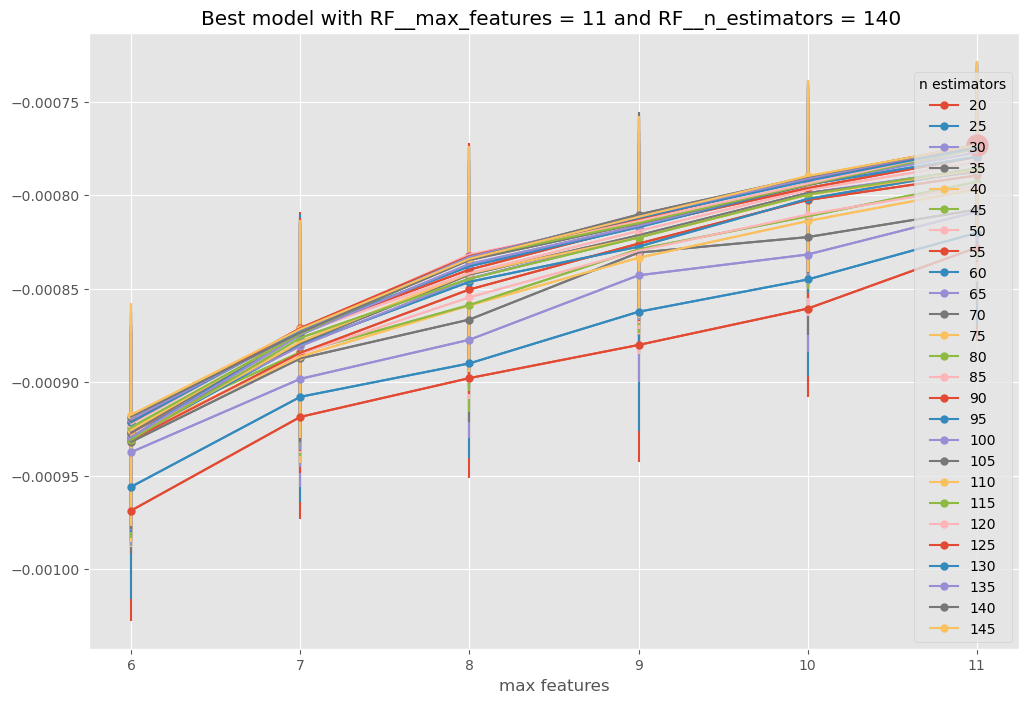

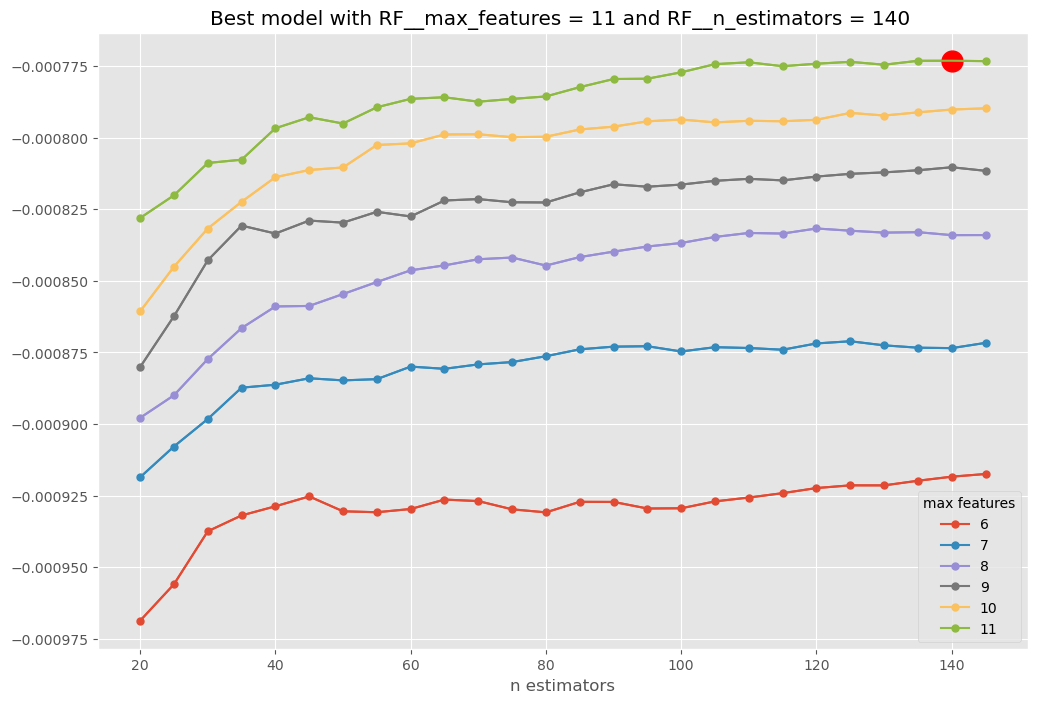

In [182]:
MT.plotModelGridError(rf_fit)

In [183]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['RF_pred'] = rf_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['RF_pred'] = rf_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['RF_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['RF_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['RF_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['RF_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['RF_pred']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['RF_pred']))

Training MAE: 0.007087158726109796
Test MAE: 0.015036079822463098
Training RMSE: 0.013228274355126074
Test RMSE: 0.027616677088548203
Training R2: 0.9869474127948931
Test R2: 0.9413590888237524


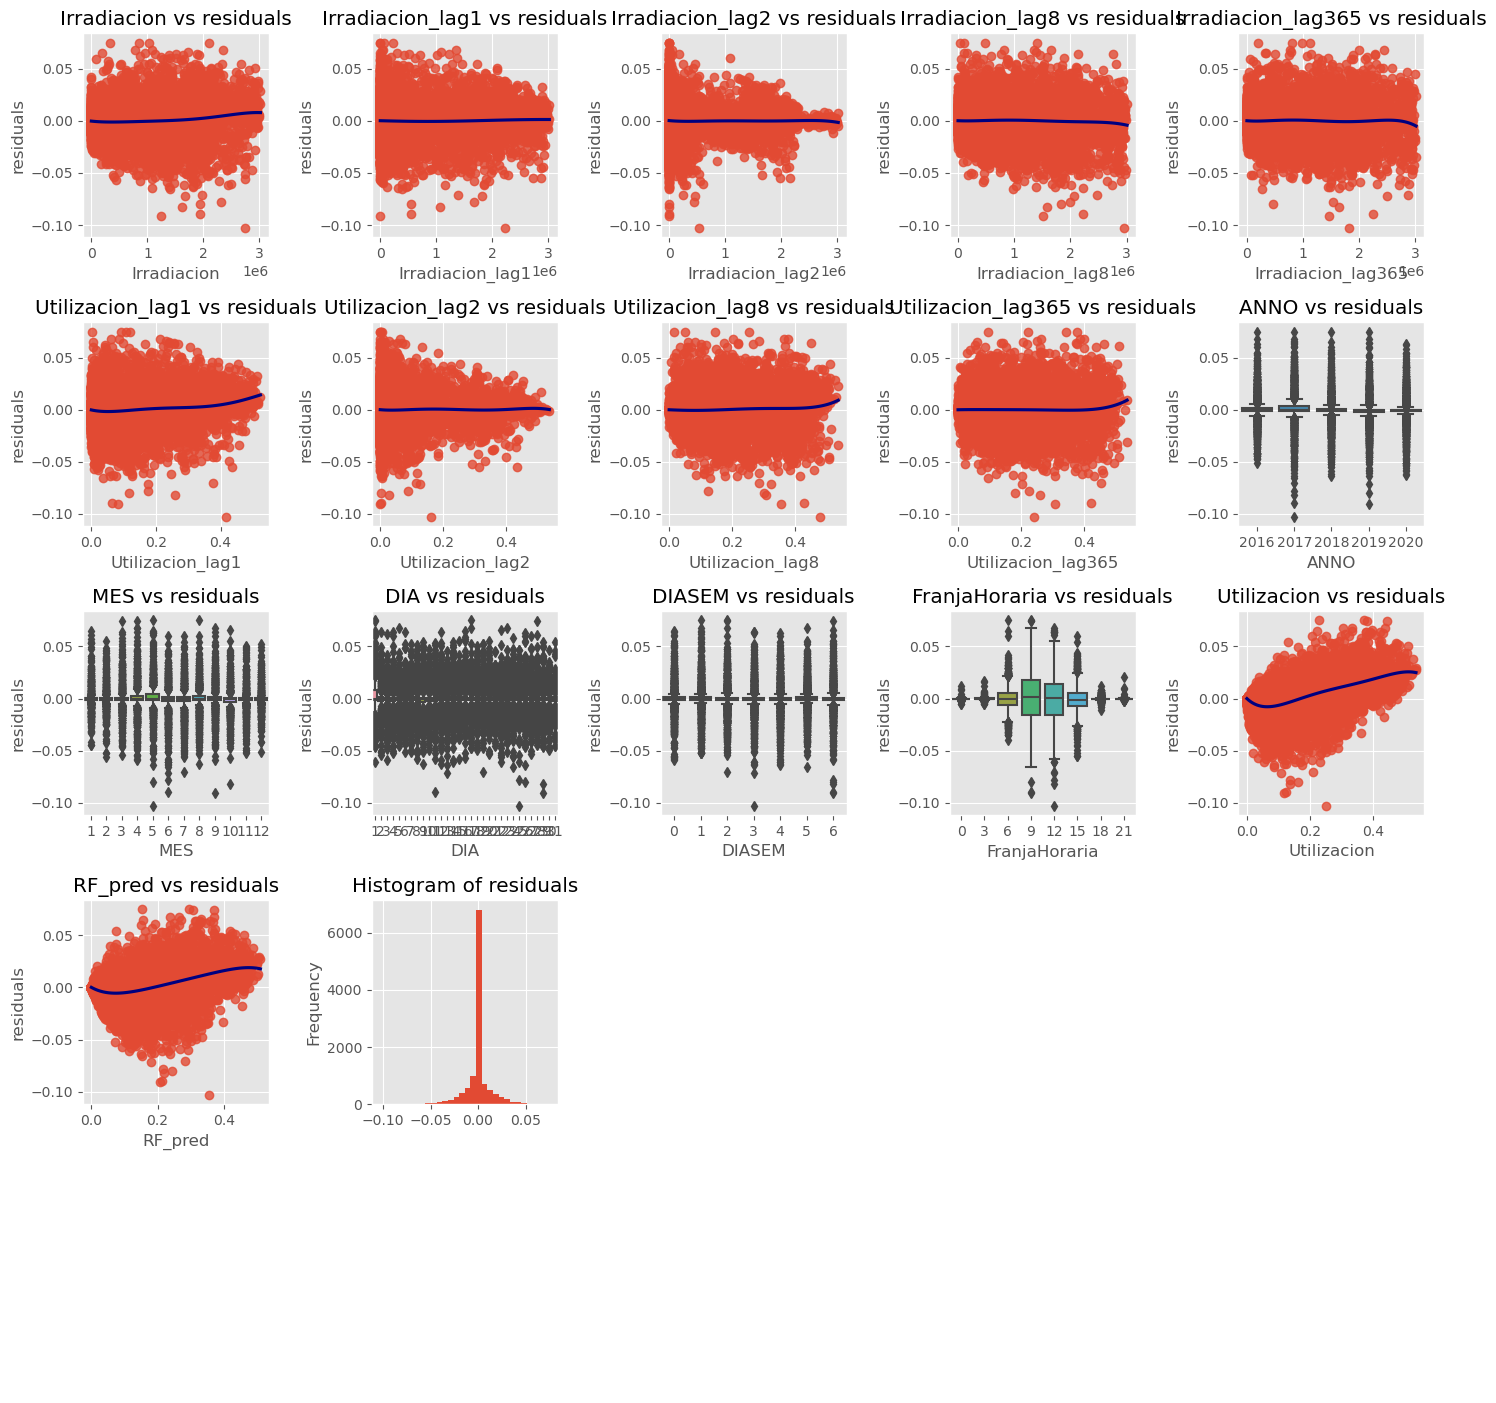

In [184]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'RF_pred', 'Utilizacion', figsize=[15,15])

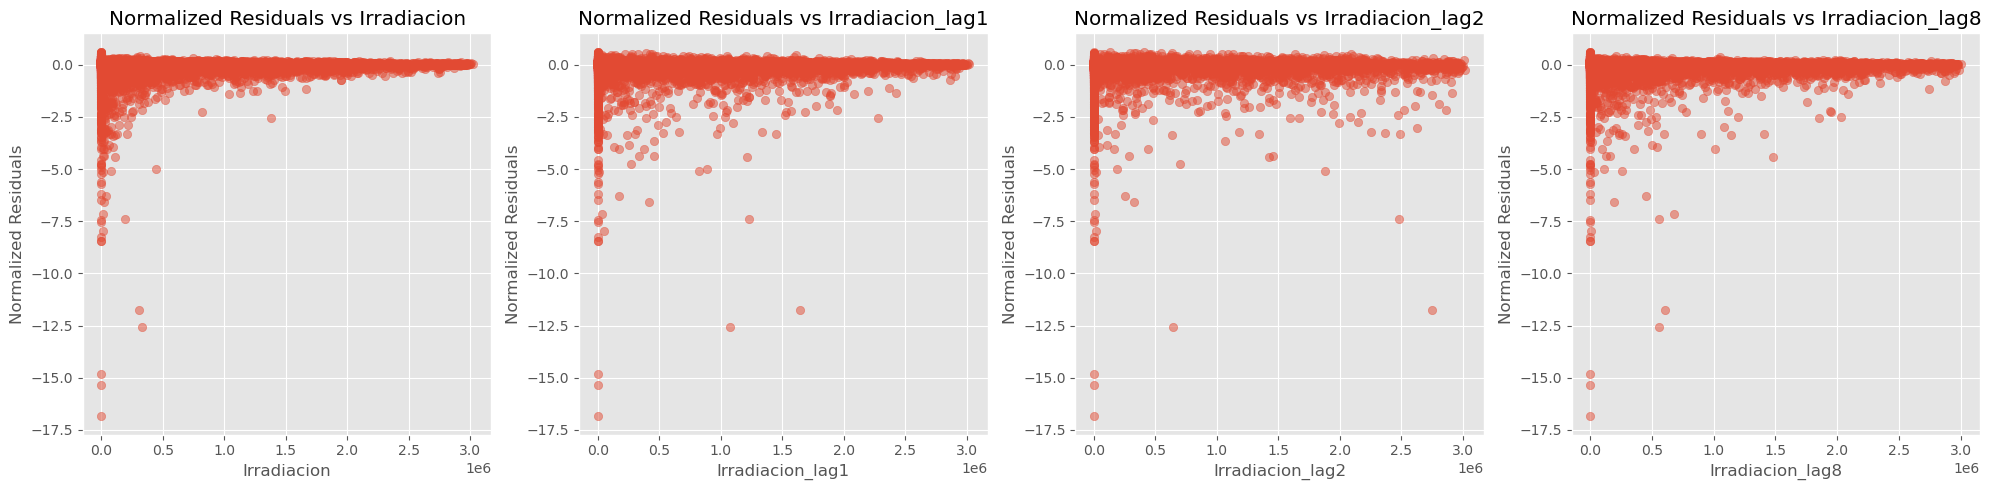

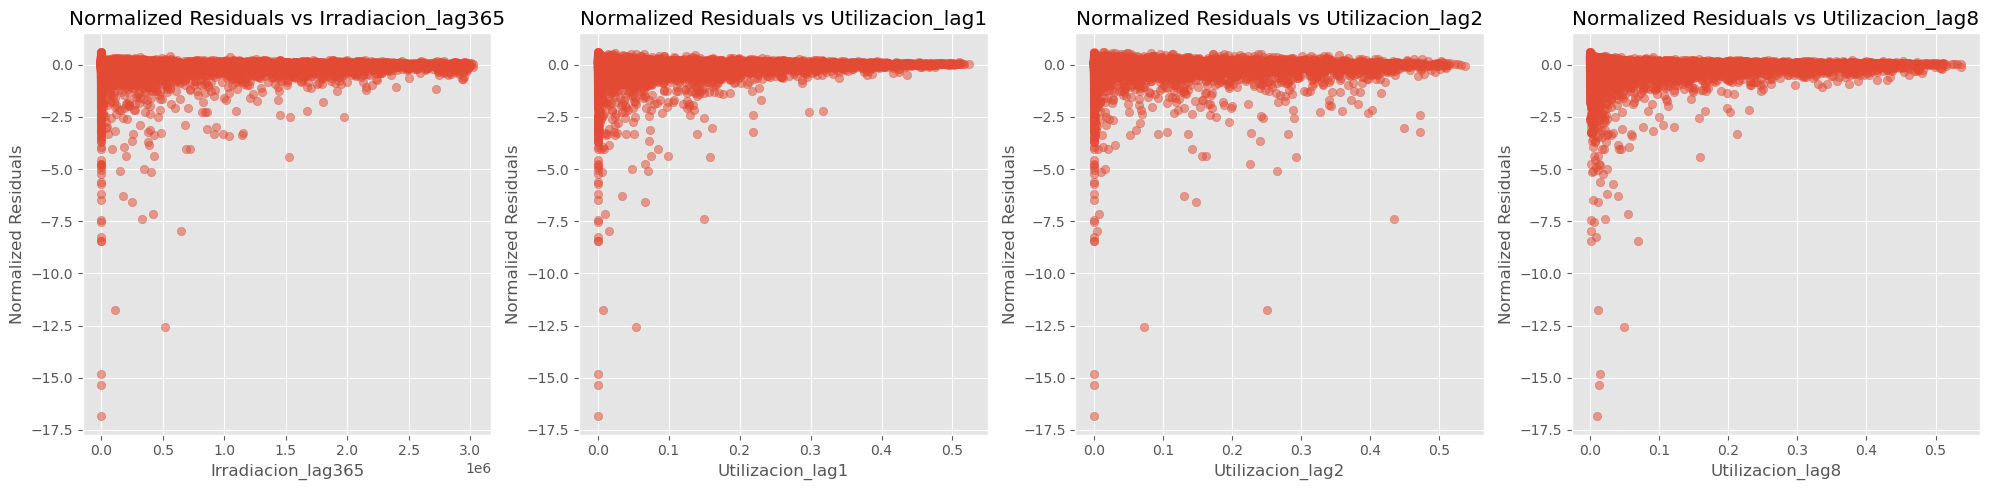

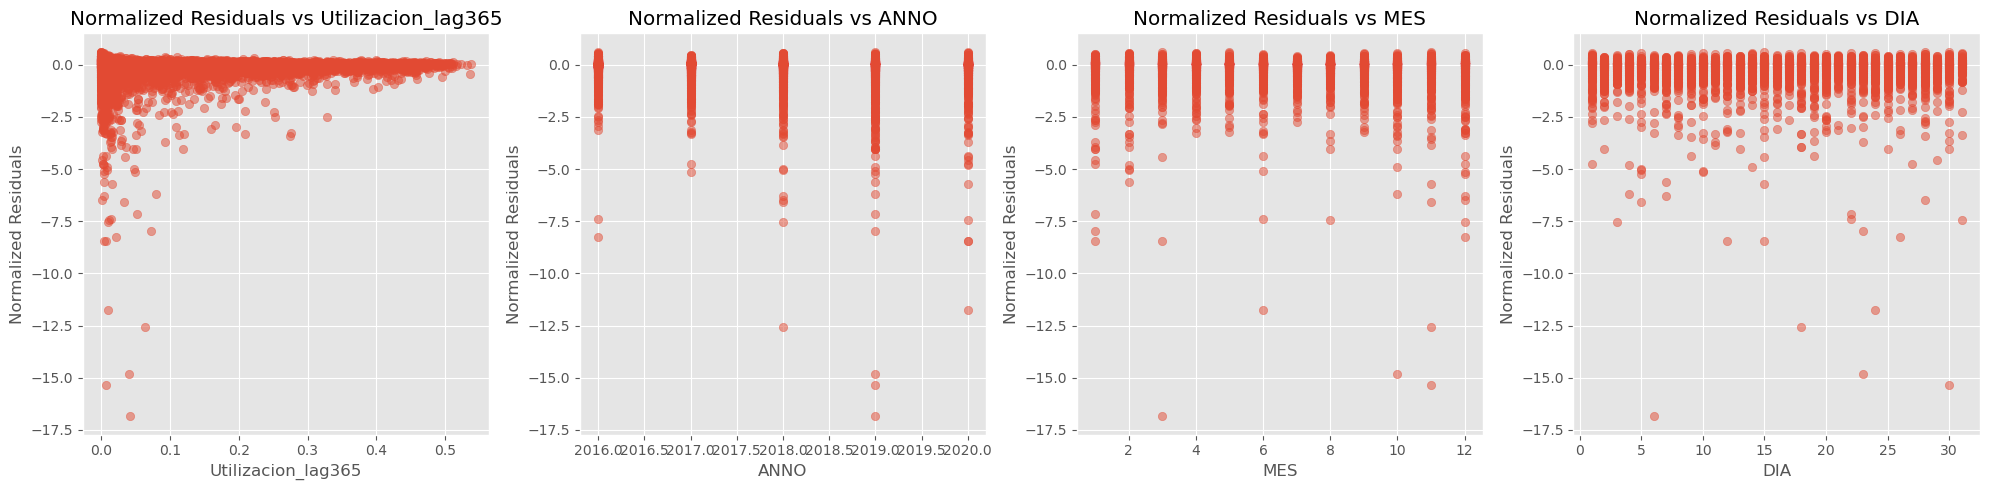

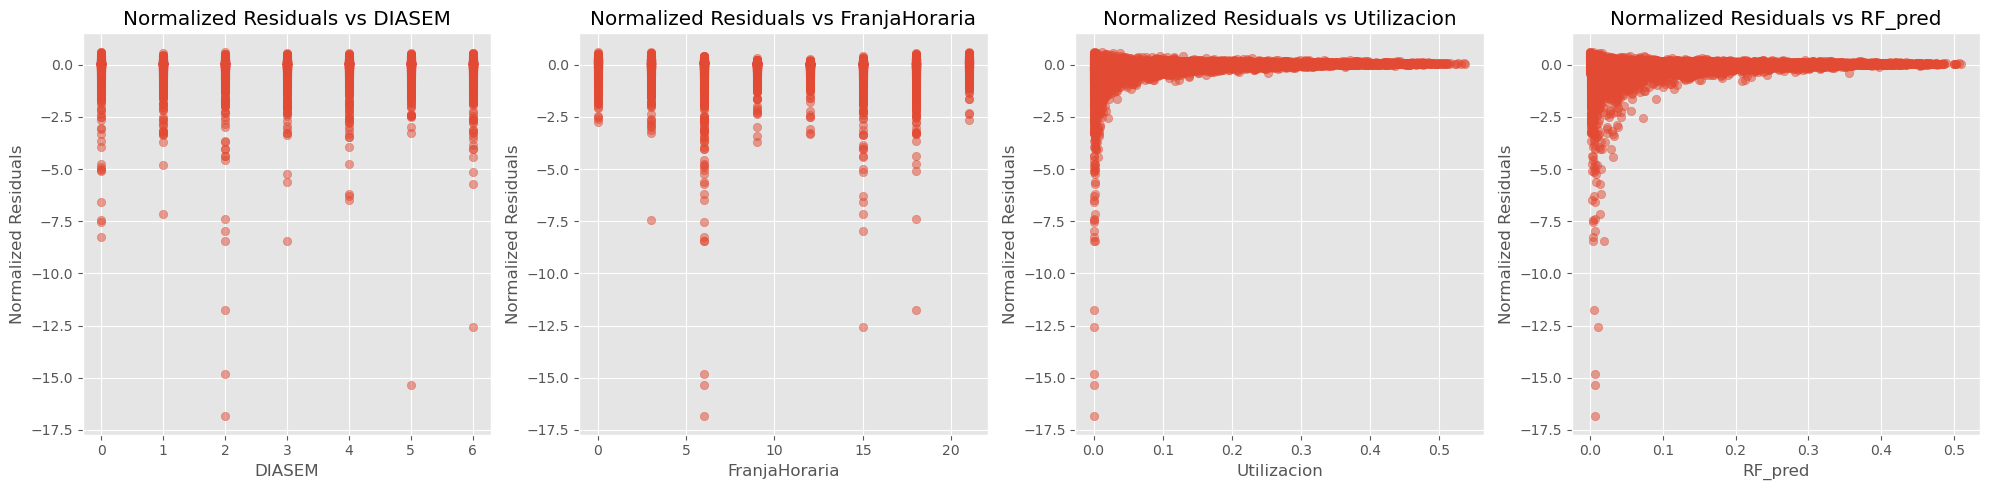

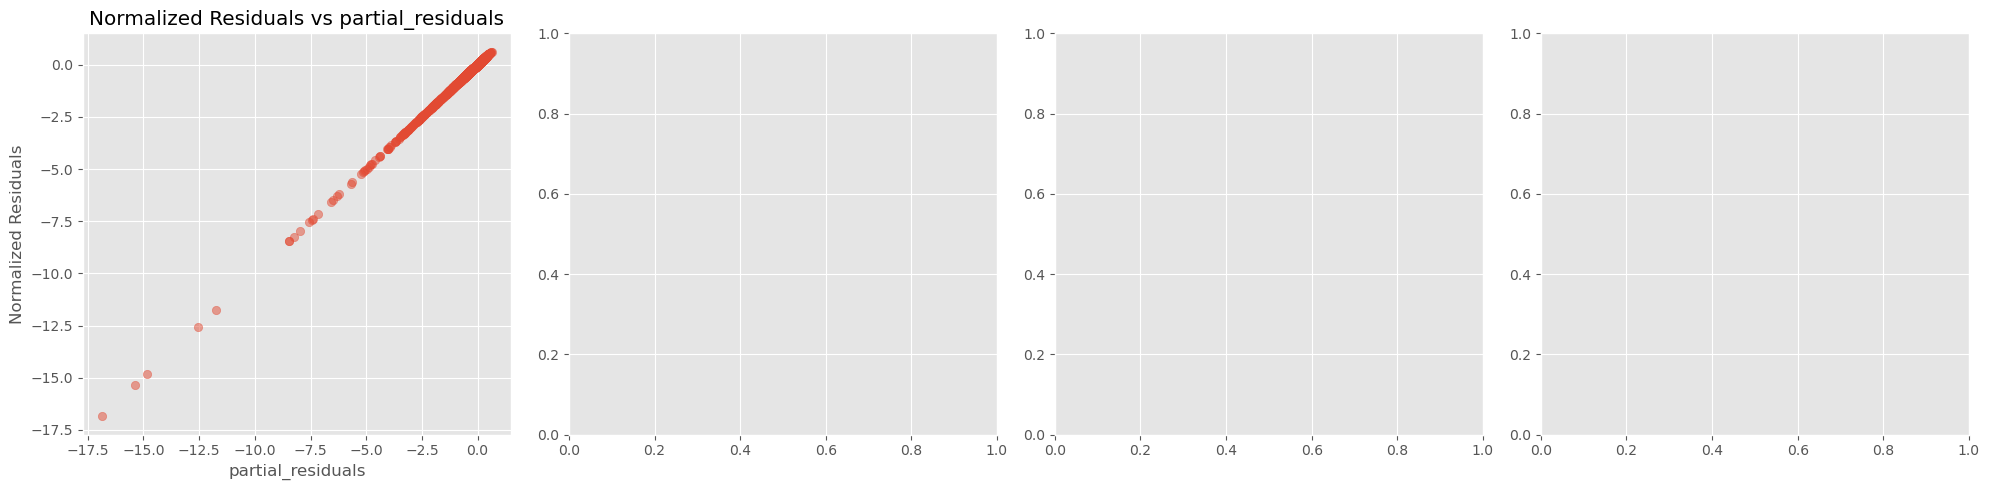

In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que 'data' es tu DataFrame que contiene las columnas 'residuals', 'utilizacion' y otras variables independientes
dfTR_eval['partial_residuals'] = dfTR_eval['residuals'] / dfTR_eval['Utilizacion']
# Obtén una lista de todas las variables independientes (excepto 'residuals' y 'utilizacion')
independent_variables = [column for column in dfTR_eval.columns if column not in ['residuals', 'utilizacion']]

# Calcula el número total de filas necesarias para organizar las gráficas
num_rows = int(np.ceil(len(independent_variables) / 4))

# Itera sobre cada variable independiente y grafica los residuos parciales frente a ella
for i in range(num_rows):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for j in range(4):
        idx = i * 4 + j
        if idx < len(independent_variables):
            variable = independent_variables[idx]
            axes[j].scatter(dfTR_eval[variable], dfTR_eval['partial_residuals'], alpha=0.5)
            axes[j].set_title(f'Normalized Residuals vs {variable}')
            axes[j].set_xlabel(variable)
            axes[j].set_ylabel('Normalized Residuals')
            axes[j].grid(True)
    plt.tight_layout()
    plt.show()